In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Flatten, Dropout, SimpleRNN, GlobalMaxPooling1D,Bidirectional, LSTM,GRU
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
!unzip twitter_sentiment.zip -d twitter_sentiment

Archive:  twitter_sentiment.zip
  inflating: twitter_sentiment/Tweets.csv  


In [4]:
df= pd.read_csv ('twitter_sentiment/Tweets.csv')

הכרות עם הנתונים ועיבוד שלהם EDA

In [6]:
df.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [7]:
df['sentiment'].nunique()

3

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
set(df['sentiment'])

{'negative', 'neutral', 'positive'}

In [9]:
df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [13]:
df = df.dropna()

In [14]:
df.isna().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [15]:
sentences = df['selected_text'].tolist()
labels = df['sentiment'].tolist()

In [17]:
#OHE
labels_encoder = LabelEncoder()
integer_incoded = labels_encoder.fit_transform(labels)
labeles_encoded = to_categorical(integer_incoded)

In [19]:
labels_encoder.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype='<U8')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(sentences,labeles_encoded, test_size =0.2, random_state =42 )

In [34]:
#tokenizing
tokenizer = Tokenizer(oov_token ='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index # לראות את המילון שהוא בנה
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding = 'pre')

In [35]:
 MAXLEN = len(train_padded[0])

In [36]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen= MAXLEN)

In [37]:
list(word_index.items())[:10]

[('<OOV>', 1),
 ('i', 2),
 ('to', 3),
 ('the', 4),
 ('a', 5),
 ('you', 6),
 ('it', 7),
 ('my', 8),
 ('and', 9),
 ('is', 10)]

In [39]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download
nltk.download('punkt_tab')#('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stop_words.discard("i")##<---
stop_words.discard("you")##<---
#stop_words.difference_update({"i", "you"}) ##<---

# יצירת פונקציה לניקוי
def clean_text(text):
    text = re.sub(r"'", "", text)  # הסרת גרשיים
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]  # lemm&stop words cleaning
    return " ".join(words)  # החזרת טקסט מעובד

# החלת הפונקציה על כל הדאטה
X_train_cleaned = [clean_text(text) for text in X_train]
X_test_cleaned = [clean_text(text) for text in X_test]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [44]:
# tokenizing training set
#tokenizing
tokenizer = Tokenizer(oov_token ='<OOV>')
tokenizer.fit_on_texts(X_train_cleaned)
word_index = tokenizer.word_index # לראות את המילון שהוא בנה
train_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
train_padded = pad_sequences(train_sequences, padding = 'pre')
# tokenizing testing set
MAXLEN = len(train_padded[0])
test_sequences = tokenizer.texts_to_sequences(X_test_cleaned)
test_padded = pad_sequences(test_sequences, maxlen= MAXLEN)

In [45]:
list(word_index.items())[:10]

[('<OOV>', 1),
 ('i', 2),
 ('you', 3),
 ('day', 4),
 ('good', 5),
 ('love', 6),
 ('happy', 7),
 ('get', 8),
 ('like', 9),
 ('go', 10)]

In [46]:
MAXLEN

27

In [51]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # יש לו נטיה לעלות
    mode = 'min', #מבטיח שיחפס ירידה בערך ולא עליה
    patience=3,          # כמה איפוקים נמתין בסבלנות
    restore_best_weights=True  # מחזיר את המשקלים של המודל למצב הטוב ביותר
)

In [54]:
def my_plot(history):
  plt.plot(history.history['loss'], label ='loss')
  plt.plot(history.history['val_loss'] ,label ='val loss')
  plt.plot(history.history['accuracy'] ,label ='acc')
  plt.plot(history.history['val_accuracy'], label ='v acc')
  plt.title(f"The best val acc was {max(history.history['val_accuracy']):.2f}")
  plt.legend()
  print(max(history.history['val_accuracy']))
  plt.show()


In [55]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    SimpleRNN(16),
    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7053 - loss: 0.7129 - val_accuracy: 0.7988 - val_loss: 0.5315
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8200 - loss: 0.5020 - val_accuracy: 0.8082 - val_loss: 0.5306
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8535 - loss: 0.4208 - val_accuracy: 0.8140 - val_loss: 0.5325
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8720 - loss: 0.3730 - val_accuracy: 0.8110 - val_loss: 0.5455
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8875 - loss: 0.3324 - val_accuracy: 0.7802 - val_loss: 0.6568
0.8140465617179871


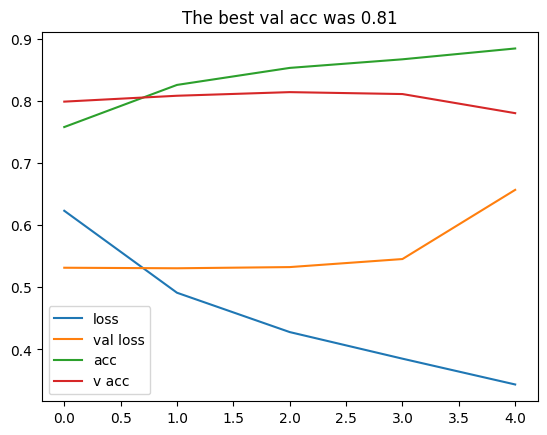

In [56]:
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])



history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6286 - loss: 0.8261 - val_accuracy: 0.7798 - val_loss: 0.5674
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8344 - loss: 0.4749 - val_accuracy: 0.8159 - val_loss: 0.5187
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8628 - loss: 0.4128 - val_accuracy: 0.8201 - val_loss: 0.5144
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8814 - loss: 0.3697 - val_accuracy: 0.8131 - val_loss: 0.5509
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8986 - loss: 0.3250 - val_accuracy: 0.8044 - val_loss: 0.6143
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9120 - loss: 0.2835 - val_accuracy: 0.7857 - val_loss: 0.6858
0.8200509548187256


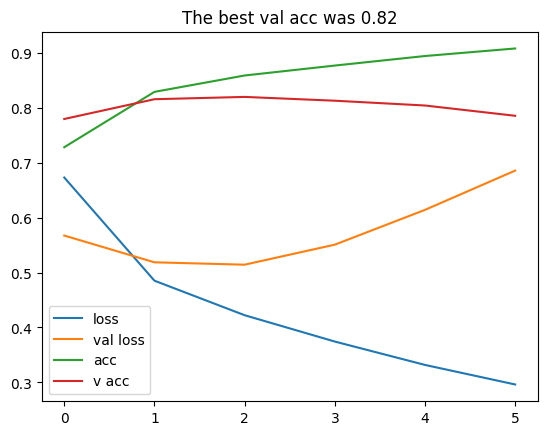

In [59]:

model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    SimpleRNN(16,return_sequences =True),# לא לשטח
    Flatten(),
    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

In [61]:
x = tf.random.normal((2,5,10))
x.shape

TensorShape([2, 5, 10])

In [66]:
rnn_layer1 = SimpleRNN(8)
output1 = rnn_layer1(x)
output1.shape

TensorShape([2, 8])

In [67]:
rnn_layer2 = SimpleRNN(8,return_sequences =True)
output2 = rnn_layer2(x)
output2.shape

TensorShape([2, 5, 8])

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6360 - loss: 0.7951 - val_accuracy: 0.7604 - val_loss: 0.6068
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8263 - loss: 0.4830 - val_accuracy: 0.7969 - val_loss: 0.5355
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8608 - loss: 0.4078 - val_accuracy: 0.7993 - val_loss: 0.5427
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8753 - loss: 0.3615 - val_accuracy: 0.8024 - val_loss: 0.5570
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8934 - loss: 0.3222 - val_accuracy: 0.8033 - val_loss: 0.5527
0.8033115267753601


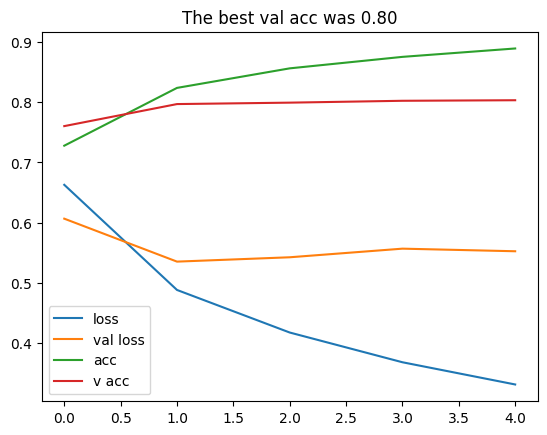

In [69]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    SimpleRNN(16,return_sequences =True),# לא לשטח
    SimpleRNN(8),

    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6107 - loss: 0.8325 - val_accuracy: 0.7959 - val_loss: 0.5371
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8280 - loss: 0.4876 - val_accuracy: 0.8171 - val_loss: 0.4986
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8594 - loss: 0.4055 - val_accuracy: 0.8168 - val_loss: 0.4953
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8820 - loss: 0.3527 - val_accuracy: 0.8173 - val_loss: 0.5253
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8965 - loss: 0.3169 - val_accuracy: 0.8130 - val_loss: 0.5136
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9023 - loss: 0.2998 - val_accuracy: 0.8115 - val_loss: 0.5573
0.8173217177391052


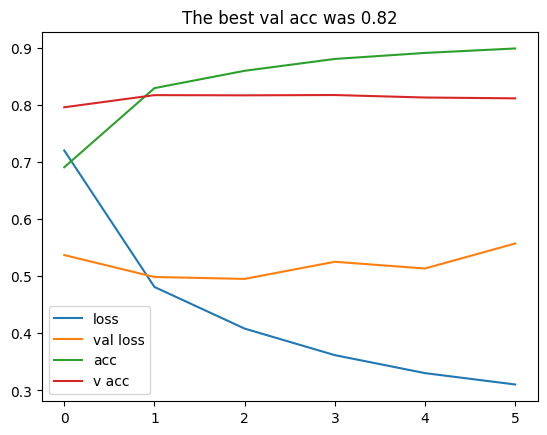

In [70]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    SimpleRNN(16,return_sequences =True),# לא לשטח

    GlobalMaxPooling1D(),
    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6834 - loss: 0.7405 - val_accuracy: 0.7913 - val_loss: 0.5455
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8214 - loss: 0.4889 - val_accuracy: 0.7988 - val_loss: 0.5364
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8485 - loss: 0.4279 - val_accuracy: 0.8079 - val_loss: 0.5386
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8738 - loss: 0.3763 - val_accuracy: 0.7988 - val_loss: 0.5601
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8896 - loss: 0.3354 - val_accuracy: 0.8029 - val_loss: 0.5918
0.807860255241394


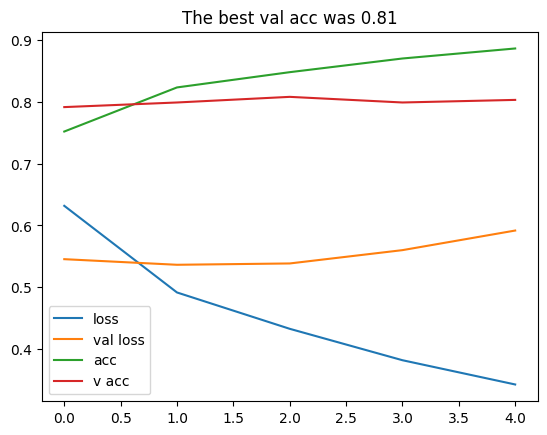

In [71]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    Bidirectional(SimpleRNN(16)),


    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.6724 - loss: 0.7672 - val_accuracy: 0.7933 - val_loss: 0.5454
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8192 - loss: 0.5013 - val_accuracy: 0.8046 - val_loss: 0.5490
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.8510 - loss: 0.4290 - val_accuracy: 0.8071 - val_loss: 0.5410
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8748 - loss: 0.3777 - val_accuracy: 0.7800 - val_loss: 0.6031
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8796 - loss: 0.3434 - val_accuracy: 0.7979 - val_loss: 0.6037
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8996 - loss: 0.3094 - val_accuracy: 0.7693 - val_loss: 0.6966
0.8071324825286865


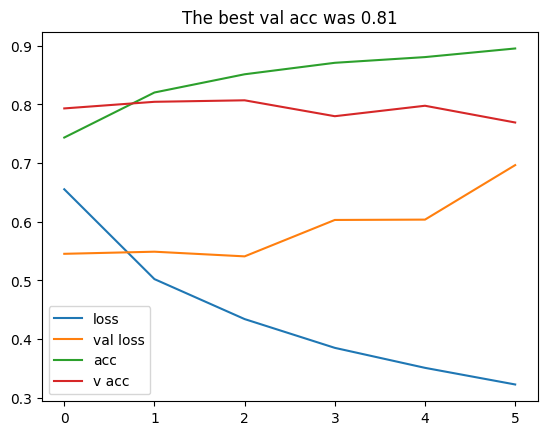

In [73]:
#Bidirectional
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    Bidirectional(SimpleRNN(16, return_sequences = True)),
    Bidirectional(SimpleRNN(16)),


    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

LSTM gates

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6519 - loss: 0.7734 - val_accuracy: 0.8046 - val_loss: 0.5227
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8359 - loss: 0.4640 - val_accuracy: 0.8160 - val_loss: 0.5105
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8690 - loss: 0.3875 - val_accuracy: 0.8213 - val_loss: 0.4874
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8875 - loss: 0.3429 - val_accuracy: 0.8177 - val_loss: 0.4902
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9004 - loss: 0.3060 - val_accuracy: 0.8188 - val_loss: 0.5313
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9109 - loss: 0.2795 - val_accuracy: 0.8117 - val_loss: 0.5239
0.8213245868682861


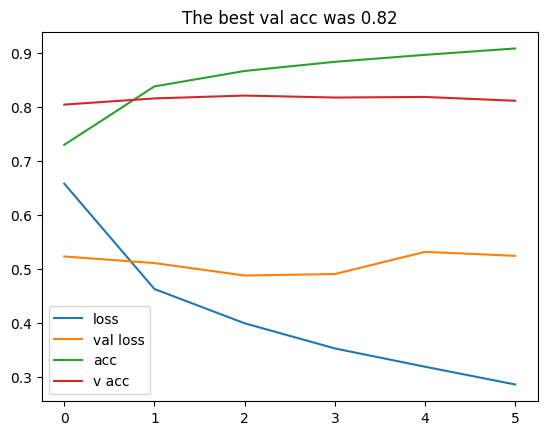

In [74]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    LSTM(16),

    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

In [ ]:
DIM =32

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.6158 - loss: 0.8257 - val_accuracy: 0.7838 - val_loss: 0.5582
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8187 - loss: 0.5050 - val_accuracy: 0.8077 - val_loss: 0.5187
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8628 - loss: 0.4088 - val_accuracy: 0.8140 - val_loss: 0.5176
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.8829 - loss: 0.3565 - val_accuracy: 0.7960 - val_loss: 0.5549
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.8971 - loss: 0.3155 - val_accuracy: 0.7904 - val_loss: 0.5626
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9102 - loss: 0.2806 - val_accuracy: 0.8068 - val_loss: 0.5432
0.8140465617179871


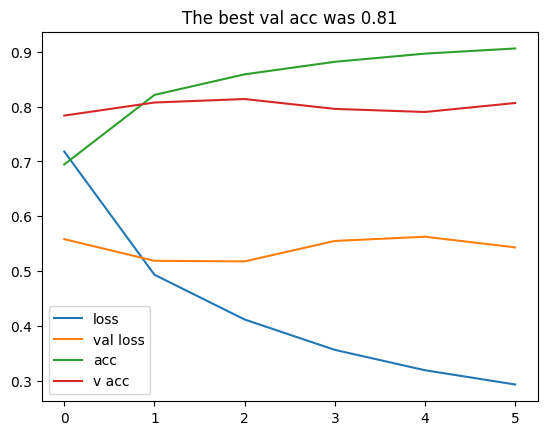

In [75]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    LSTM(16, return_sequences =True),
    LSTM(8),

    #NN
    Dense(DIM, activation ='relu'),
    Dense(DIM/2, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6055 - loss: 0.8377 - val_accuracy: 0.7751 - val_loss: 0.5793
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.8218 - loss: 0.4967 - val_accuracy: 0.8155 - val_loss: 0.5073
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.8568 - loss: 0.4230 - val_accuracy: 0.8173 - val_loss: 0.5121
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.8818 - loss: 0.3568 - val_accuracy: 0.8160 - val_loss: 0.5347
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8960 - loss: 0.3229 - val_accuracy: 0.8193 - val_loss: 0.5097
0.8193231225013733


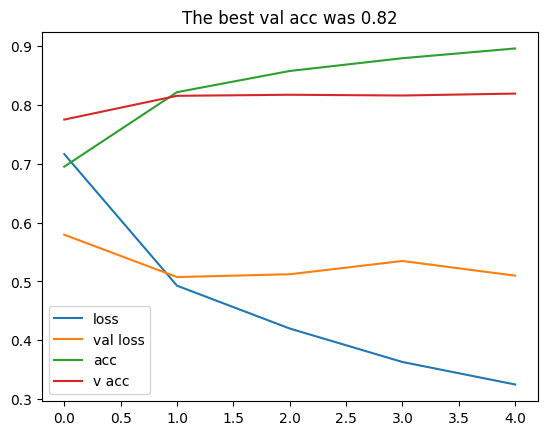

In [76]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    LSTM(16, return_sequences =True),
    LSTM(8),

    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6410 - loss: 0.7843 - val_accuracy: 0.8057 - val_loss: 0.5286
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8400 - loss: 0.4605 - val_accuracy: 0.8195 - val_loss: 0.4914
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8677 - loss: 0.3940 - val_accuracy: 0.8215 - val_loss: 0.4970
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8823 - loss: 0.3568 - val_accuracy: 0.8211 - val_loss: 0.5067
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8972 - loss: 0.3191 - val_accuracy: 0.8088 - val_loss: 0.5503
0.8215065598487854


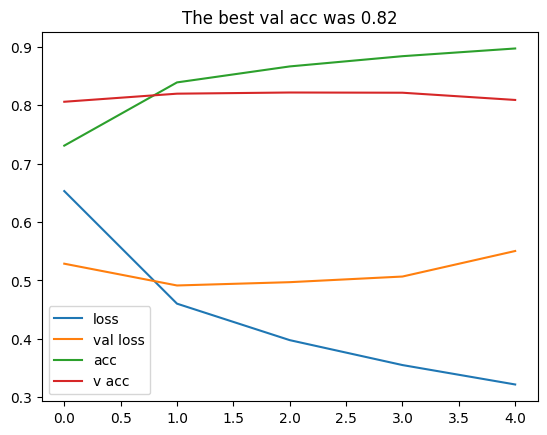

In [77]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    Bidirectional(LSTM(16)),


    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.6999 - loss: 0.7061 - val_accuracy: 0.8073 - val_loss: 0.5206
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8426 - loss: 0.4550 - val_accuracy: 0.8233 - val_loss: 0.4953
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8699 - loss: 0.3932 - val_accuracy: 0.8182 - val_loss: 0.4887
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8900 - loss: 0.3389 - val_accuracy: 0.8162 - val_loss: 0.4902
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8983 - loss: 0.3092 - val_accuracy: 0.8128 - val_loss: 0.5100
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9039 - loss: 0.2992 - val_accuracy: 0.8013 - val_loss: 0.5636
0.823326051235199


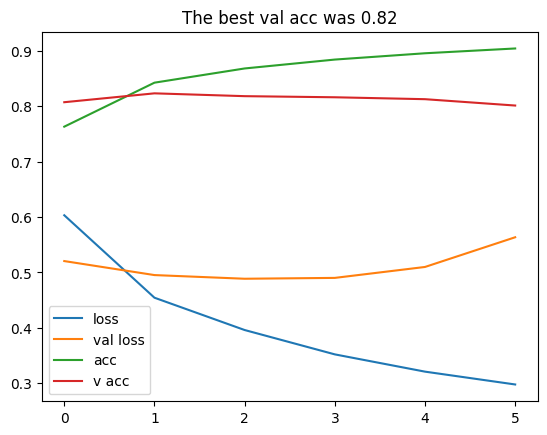

In [79]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    GRU(16),


    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.6584 - loss: 0.7648 - val_accuracy: 0.8104 - val_loss: 0.5150
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8384 - loss: 0.4618 - val_accuracy: 0.8086 - val_loss: 0.5224
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8747 - loss: 0.3794 - val_accuracy: 0.8148 - val_loss: 0.5060
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8908 - loss: 0.3397 - val_accuracy: 0.8133 - val_loss: 0.5193
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9030 - loss: 0.3058 - val_accuracy: 0.8137 - val_loss: 0.5362
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9139 - loss: 0.2789 - val_accuracy: 0.7977 - val_loss: 0.5651
0.8147743940353394


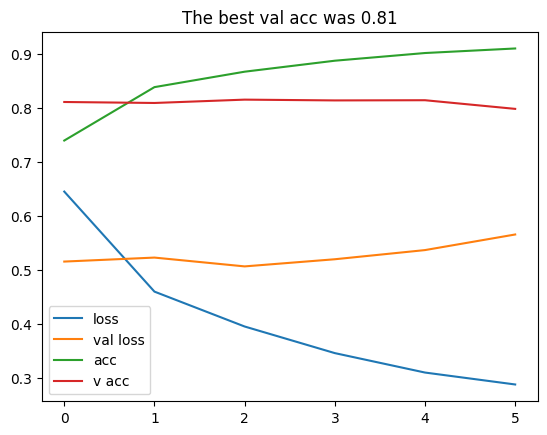

In [81]:
model = Sequential([
    Embedding(input_dim =len(word_index)+1,
              output_dim =10),
    GRU(16, return_sequences =True),
    SimpleRNN(8),


    #NN
    Dense(32, activation ='relu'),
    Dropout(0.3),
    Dense(3,activation ='softmax')
])
model.compile(loss ='categorical_crossentropy',
                 optimizer =RMSprop(learning_rate =0.005),
                 metrics = ['accuracy'])


history = model.fit(train_padded,
                    y_train,
                    validation_data= (test_padded, y_test),
                    callbacks = early_stopping,
                    epochs =20)

my_plot(history)